# Clasificación de Imágenes con Modelo de PyTorch (Torchvision)

Este cuaderno está dedicado a la investigación y entrenamiento de un modelo básico de Tensorflow, usando Torchvision.

Tanto el modelo como las transformaciones han cambiado respecto al resto de modelos.
La única similitud se mantiene en la carga de datos y la representación de imágenes, que se basan en código de python normal.

## Imports

In [2]:
import os
import tifffile
import tempfile
import re
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
from tqdm import tqdm
from torch.hub import load_state_dict_from_url
from torchvision import transforms 
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import Compose, RandomRotation, RandomHorizontalFlip, RandomVerticalFlip, RandomResizedCrop, ColorJitter, ToTensor, Normalize, ToPILImage, Lambda, Resize
import numpy as np
import random
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from typing import Sequence


## Celulas de Entrenamiento y Test

Recoge las células de entrenamiento y de test de cada una de 

In [4]:
root_dir = "/home/jose/TFG/Data/Celulas"

# Directorio que contiene tus datos locales
data_dir_train = os.path.join(root_dir, "entrenamiento")
data_dir_test = os.path.join(root_dir, "test")

if not os.path.exists(data_dir_train):
    raise FileNotFoundError(f"El directorio de datos de entrenamiento {data_dir_train} no existe.")
if not os.path.exists(data_dir_test):
    raise FileNotFoundError(f"El directorio de datos de prueba {data_dir_test} no existe.")
print(data_dir_train)
print(data_dir_test)

/home/jose/TFG/Data/Celulas/entrenamiento
/home/jose/TFG/Data/Celulas/test


## Semilla determinista

In [5]:
torch.manual_seed(5)

## Cargar los Datafolders


Total de imágenes: 1743
Dimensiones de las imágenes: 200 x 200
Nombres de las etiquetas: ['altogrado', 'ascus', 'bajogrado', 'benigna']
Número de imágenes por etiqueta: [879, 389, 293, 182]


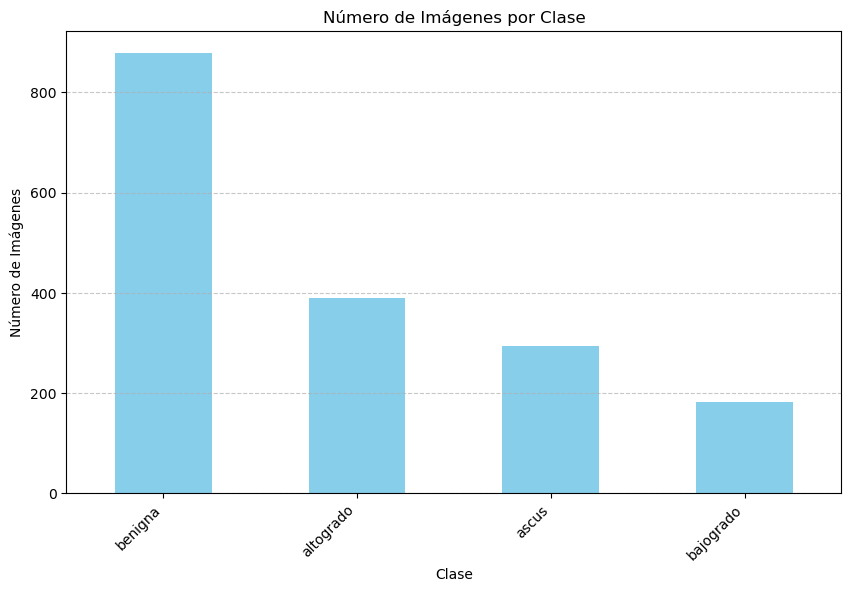

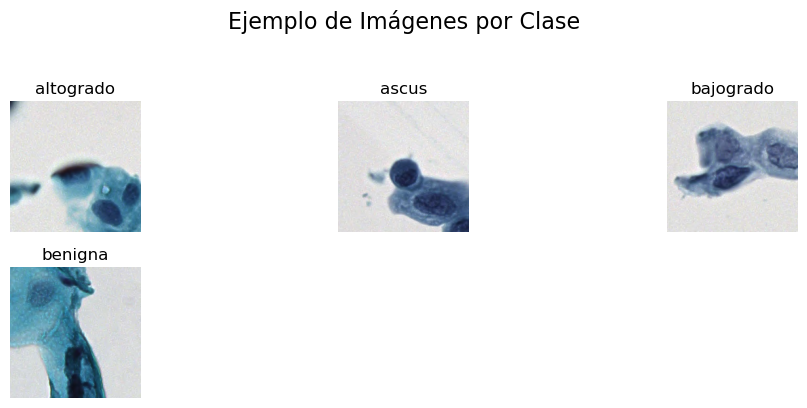

In [6]:
# Obtener los nombres de las clases de entrenamiento
class_names_train = sorted(x for x in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, x)) and x != '.ipynb_checkpoints')
num_class_train = len(class_names_train)

# Obtener la lista de rutas a las imágenes TIFF y las etiquetas de clase correspondientes
image_files_list_train = []
image_class_train = []

for i, class_name_train in enumerate(class_names_train):
    class_dir_train = os.path.join(data_dir_train, class_name_train)
    image_files_train = [os.path.join(class_dir_train, x) for x in os.listdir(class_dir_train) if x.endswith('.tiff') and not x.startswith('.')]  # Filtrar archivos TIFF y ocultos
    image_files_list_train.extend(image_files_train)
    image_class_train.extend([class_name_train] * len(image_files_train))  

# Crear un DataFrame con las rutas de las imágenes y las etiquetas de clase
df_train = pd.DataFrame({
    'image_path': image_files_list_train,
    'class_name': image_class_train
})

num_total_train = len(image_class_train)
image_width, image_height = Image.open(image_files_list_train[0]).size

# Mostrar información sobre los datos
print(f"Total de imágenes: {num_total_train}")
print(f"Dimensiones de las imágenes: {image_width} x {image_height}")
print(f"Nombres de las etiquetas: {class_names_train}")
print(f"Número de imágenes por etiqueta: {df_train['class_name'].value_counts().tolist()}")

# Gráfico de barras para mostrar el número de imágenes por etiqueta de clase
plt.figure(figsize=(10, 6))
df_train['class_name'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Número de Imágenes por Clase')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Mostrar una muestra de una imagen por clase
plt.figure(figsize=(10, 6))
num_classes_display = min(9, len(class_names_train))
for i, class_name in enumerate(class_names_train[:num_classes_display]):
    class_sample = df_train[df_train['class_name'] == class_name].sample(n=1).iloc[0]
    image = Image.open(class_sample['image_path'])
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.suptitle('Ejemplo de Imágenes por Clase', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Celulas de prueba

Total de imágenes: 120
Dimensiones de las imágenes: 200 x 200
Nombres de las etiquetas: ['altogrado', 'ascus', 'bajogrado', 'benigna']
Número de imágenes por etiqueta: [30, 30, 30, 30]


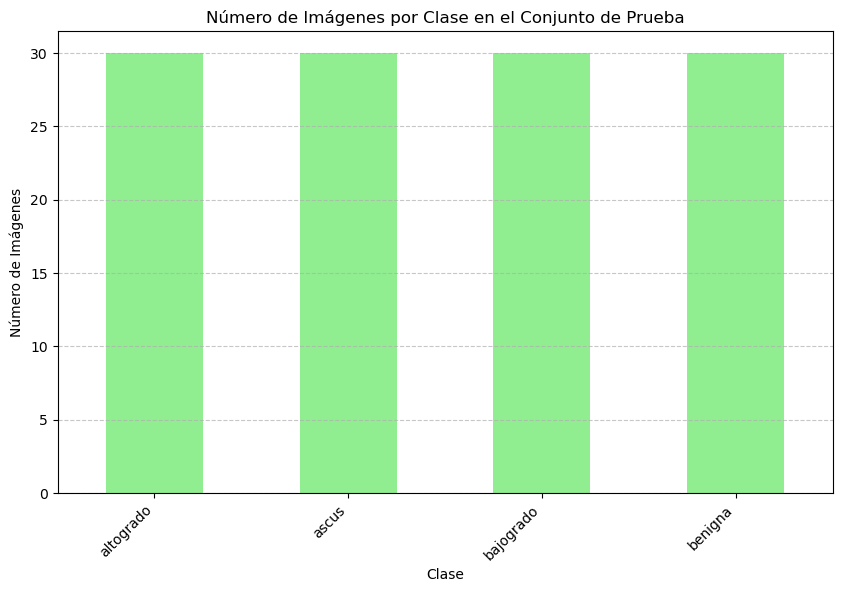

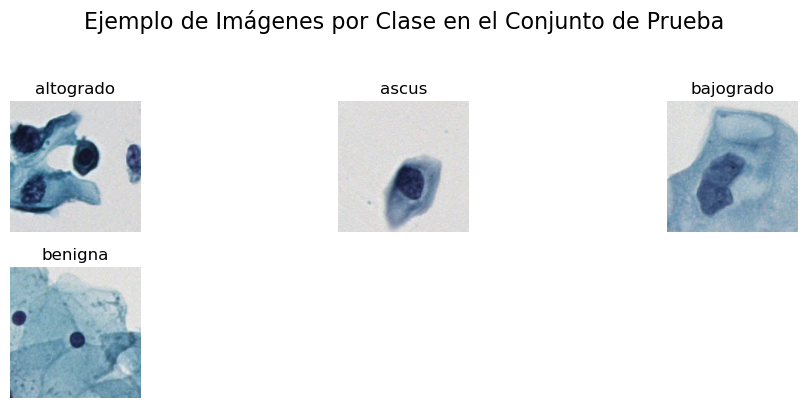

In [7]:
# Obtener nombres de las clases
class_names_test = sorted([x for x in os.listdir(data_dir_test) if os.path.isdir(os.path.join(data_dir_test, x)) and x != '.ipynb_checkpoints'])
num_class_test = len(class_names_test)

# Función para obtener rutas de imágenes y sus etiquetas
def get_image_files_and_labels(class_name):
    class_dir = os.path.join(data_dir_test, class_name)
    image_files = [os.path.join(class_dir, x) for x in os.listdir(class_dir) if x.endswith('.tiff') and not x.startswith('.')]
    return image_files, [class_name] * len(image_files)

# Usar ThreadPoolExecutor para paralelizar la lectura de archivos
image_files_list_test = []
image_class_test = []

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(get_image_files_and_labels, class_name) for class_name in class_names_test]
    for future in futures:
        image_files, labels = future.result()
        image_files_list_test.extend(image_files)
        image_class_test.extend(labels)

num_total_test = len(image_class_test)

# Leer una imagen para obtener las dimensiones
sample_image = PIL.Image.open(image_files_list_test[0])
image_width, image_height = sample_image.size

# Crear un DataFrame para manejar los datos
df_test = pd.DataFrame({
    'image_path': image_files_list_test,
    'class_name': image_class_test
})

# Mostrar información sobre los datos de prueba
print(f"Total de imágenes: {num_total_test}")
print(f"Dimensiones de las imágenes: {image_width} x {image_height}")
print(f"Nombres de las etiquetas: {class_names_test}")
print(f"Número de imágenes por etiqueta: {df_test['class_name'].value_counts().tolist()}")

# Gráfico de barras para mostrar el número de imágenes por etiqueta de clase en el conjunto de prueba
plt.figure(figsize=(10, 6))
df_test['class_name'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Número de Imágenes por Clase en el Conjunto de Prueba')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Mostrar una muestra de una imagen por clase en el conjunto de prueba
plt.figure(figsize=(10, 6))
num_classes_display = min(9, len(class_names_test))
for i, class_name in enumerate(class_names_test[:num_classes_display]):
    class_sample = df_test[df_test['class_name'] == class_name].sample(n=1).iloc[0]
    image = PIL.Image.open(class_sample['image_path'])
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.suptitle('Ejemplo de Imágenes por Clase en el Conjunto de Prueba', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## IMÁGENES DE ENTRENAMIENTO

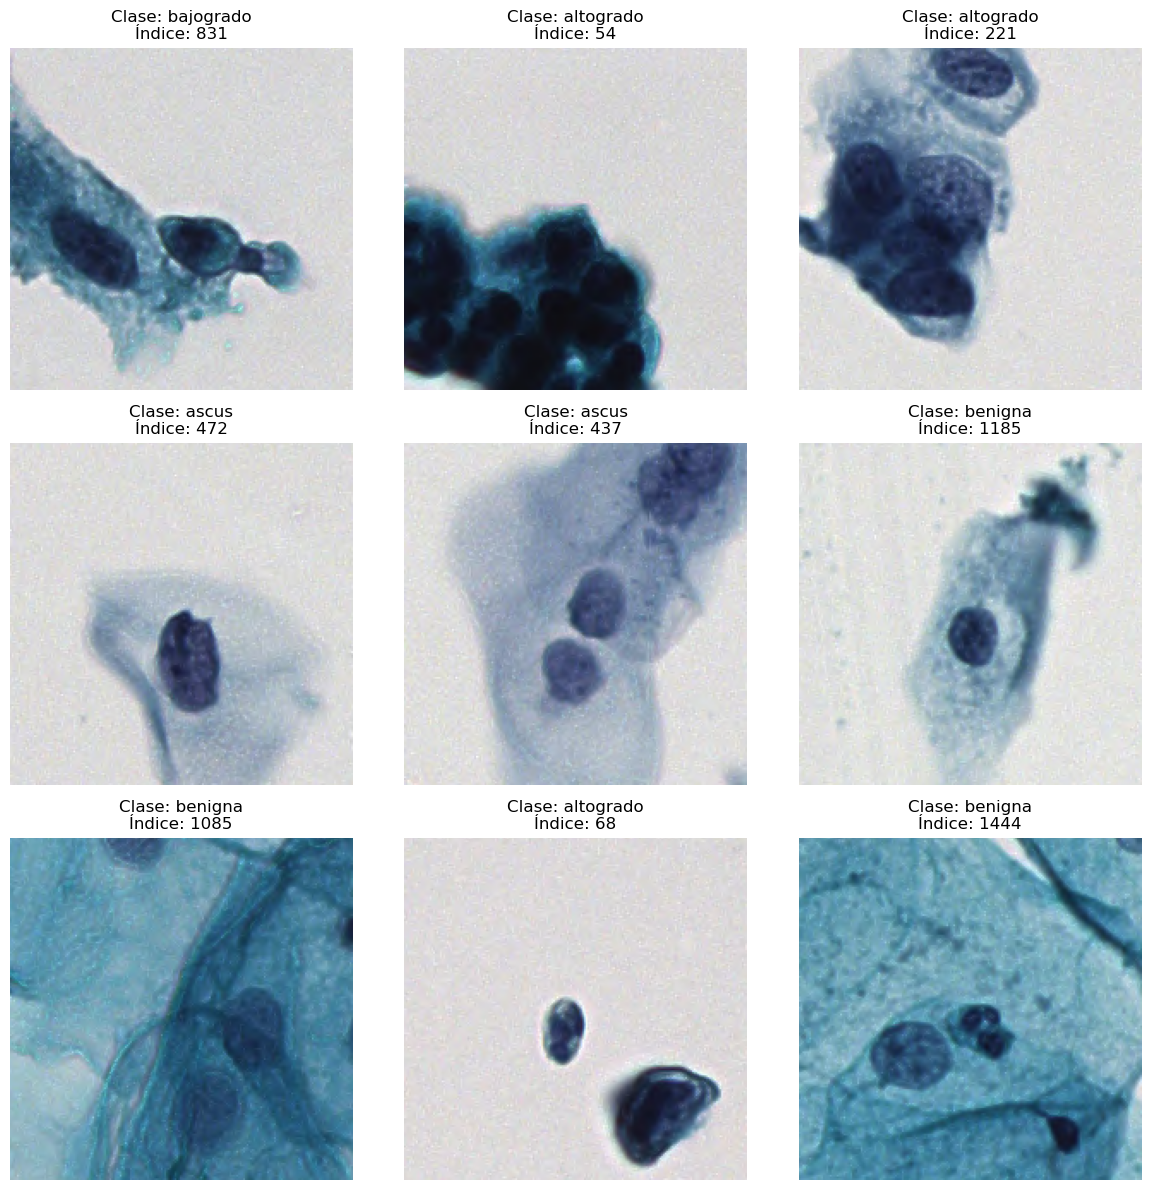

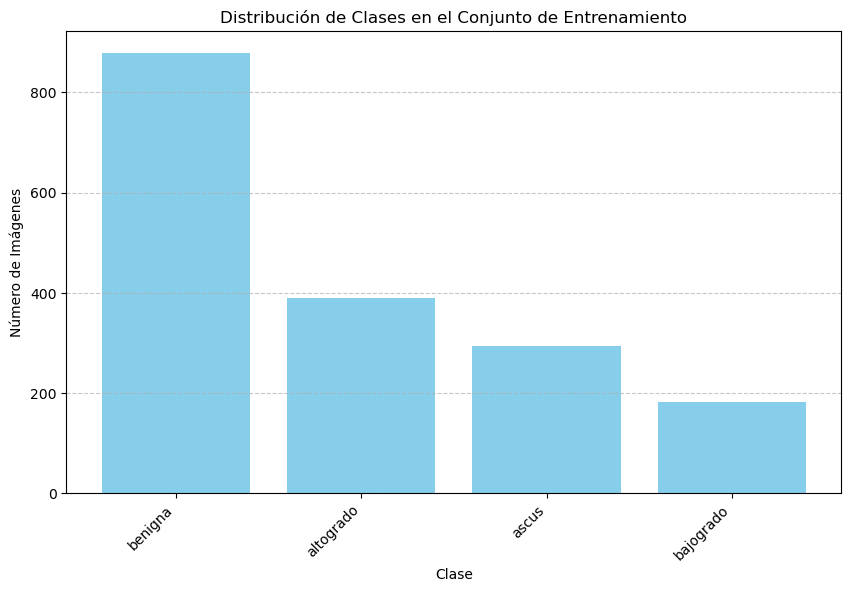

In [8]:
# Crear subgráficos
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
random_indices = np.random.choice(num_total_train, size=9, replace=False)

# Mostrar las imágenes y etiquetas
for i, idx in enumerate(random_indices):
    ax = axs[i // 3, i % 3]
    image_path = image_files_list_train[idx]
    image = PIL.Image.open(image_path)
    ax.imshow(image, cmap="gray", vmin=0, vmax=255)
    class_name = image_class_train[idx]
    ax.set_title(f"Clase: {class_name}\nÍndice: {idx}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Crear un DataFrame para la distribución de clases
class_distribution = df_train['class_name'].value_counts().reset_index()
class_distribution.columns = ['class_name', 'count']

# Mostrar gráfico de barras de la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_distribution['class_name'], class_distribution['count'], color='skyblue')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## IMAGENES DE PRUEBA

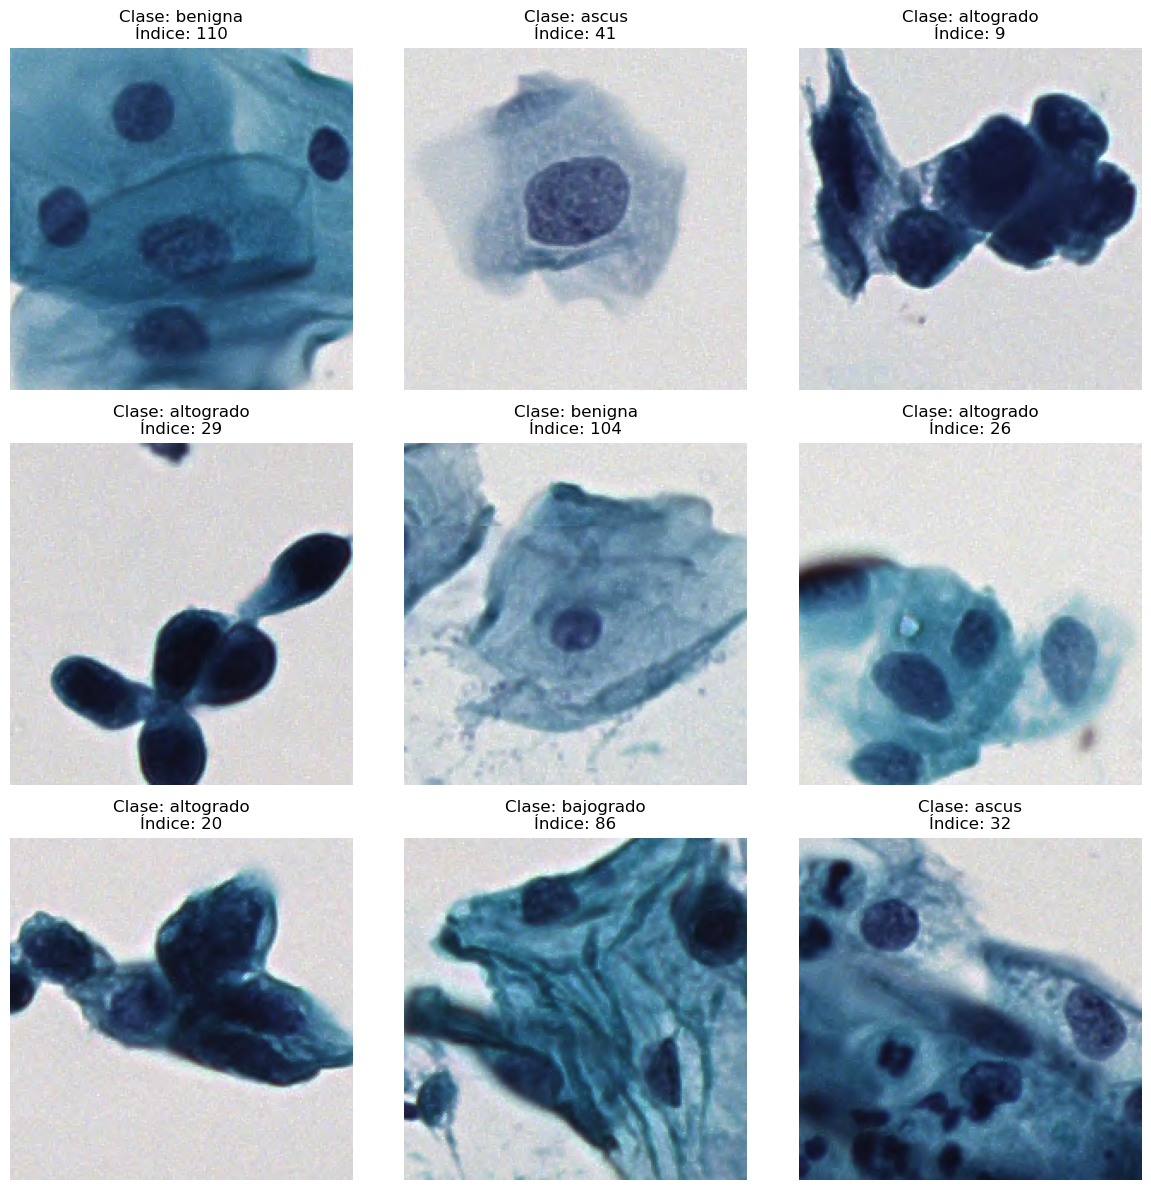

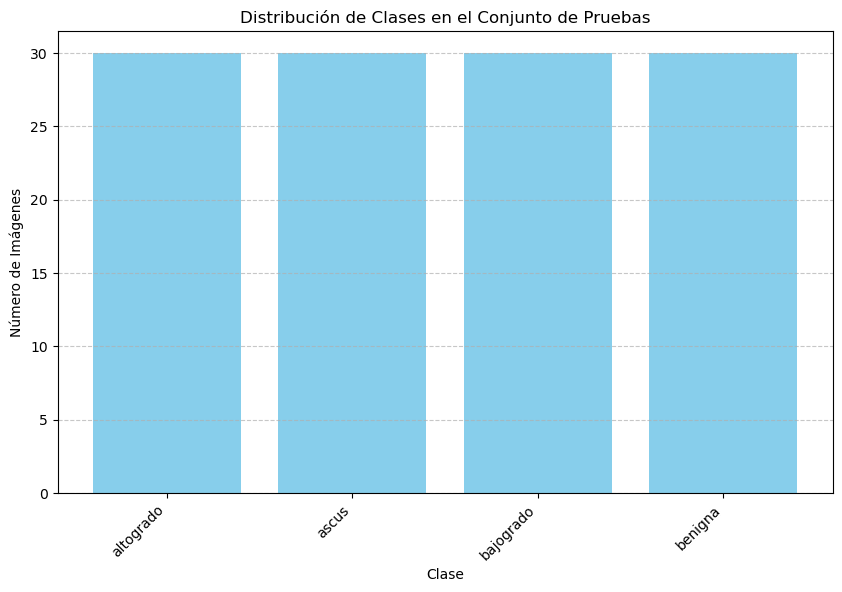

In [9]:
# Crear subgráficos
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
random_indices = np.random.choice(num_total_test, size=9, replace=False)

# Mostrar las imágenes y etiquetas
for i, idx in enumerate(random_indices):
    ax = axs[i // 3, i % 3]
    image_path = image_files_list_test[idx]
    image = PIL.Image.open(image_path)
    ax.imshow(image, cmap="gray", vmin=0, vmax=255)
    class_name = image_class_test[idx]
    ax.set_title(f"Clase: {class_name}\nÍndice: {idx}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Crear un DataFrame para la distribución de clases
class_distribution_test = pd.DataFrame({
    'class_name': image_class_test
})
class_distribution_test = class_distribution_test['class_name'].value_counts().reset_index()
class_distribution_test.columns = ['class_name', 'count']

# Mostrar gráfico de barras de la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_distribution_test['class_name'], class_distribution_test['count'], color='skyblue')
plt.title('Distribución de Clases en el Conjunto de Pruebas')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Preparar conjunto de datos de entrenamiento, validación y test

Se elige de manera aleatoria un 10% de los datos de entrenamiento para la validación.

In [10]:
#Aquí puedes especificar el porcentaje de validación
val_frac = 0.1


length_train = len(image_files_list_train)
length_test = len(image_files_list_test)
indices_train = np.arange(length_train)
indices_test = np.arange(length_test)
np.random.shuffle(indices_train)
np.random.shuffle(indices_test)
test_split = int(length_test)
val_split = int(val_frac * length_train) + test_split
test_indices = indices_test[:test_split]
val_indices = indices_train[test_split:val_split]
train_indices = indices_train[val_split:]

train_x = [image_files_list_train[i] for i in train_indices]
train_y = [image_class_train[i] for i in train_indices]
val_x = [image_files_list_train[i] for i in val_indices]
val_y = [image_class_train[i] for i in val_indices]
test_x = [image_files_list_test[i] for i in test_indices]
test_y = [image_class_test[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 1449, Validation count: 174, Test count: 120


## Definición de las Transformaciones y Balanceo de Clases

In [11]:
# Transformaciones PyTorch
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Calcular la distribución de clases en el conjunto de datos original de entrenamiento

class_counter_train = Counter(train_y)
min_class_count = min(class_counter_train.values())
print(min_class_count)
max_random_images = min_class_count - 1
print(max_random_images)
total_images_train = len(train_y)
print(total_images_train)
extra_images_needed = max_random_images * len(class_counter_train) - total_images_train
print(extra_images_needed)

# Ajustar el número de imágenes aleatorias por clase para igualar las clases

class_random_images = {cls: max_random_images for cls in class_counter_train.keys()}
print(class_random_images)
for cls, count in class_counter_train.items():
    if extra_images_needed > 0:
        additional_images = min(extra_images_needed, max_random_images)
        class_random_images[cls] += additional_images
        extra_images_needed -= additional_images

# Número de imágenes aleatorias que deseas generar por cada imagen original
num_random_images = 40

# Clase de Dataset con transformaciones aleatorias
class RandomTransformDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms, num_random_images):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
        self.num_random_images = num_random_images
        self.random_transforms = transforms

    def __len__(self):
        return len(self.image_files) * (self.num_random_images + 1)

    def __getitem__(self, index):
        original_index = index // (self.num_random_images + 1)
        filename = self.image_files[original_index]
        original_image = tifffile.imread(filename) 

        # Convertir a float y normalizar si es necesario
        if original_image.dtype != np.float32:
            original_image = original_image.astype(np.float32) / np.iinfo(original_image.dtype).max

        if index % (self.num_random_images + 1) == 0:
            # Apply original transformations
            original_image = self.transforms(original_image)
            return original_image, self.labels[original_index]
        else:
            random_image = self.random_transforms(original_image)
            random_image = self.transforms(random_image)
            return random_image, self.labels[original_index]



160
159
1449
-813
{'altogrado': 159, 'benigna': 159, 'bajogrado': 159, 'ascus': 159}


## Cargar datos de Entrenamiento, Validación y Prueba

In [12]:
# Crear el conjunto de datos de entrenamiento con las transformaciones aleatorias proporcionales
train_random_x = []
train_random_y = []
for x, y in zip(train_x, train_y):
    train_random_x.extend([x] * (class_random_images[y] + 1))
    train_random_y.extend([y] * (class_random_images[y] + 1))

# Conjunto de datos de entrenamiento
train_ds = RandomTransformDataset(train_x, train_y, train_transforms, max_random_images)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)

# Conjunto de datos de validación
val_ds = RandomTransformDataset(val_x, val_y, val_transforms, max_random_images)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=4)


# Conjunto de datos de prueba
test_ds = RandomTransformDataset(test_x, test_y, val_transforms, max_random_images)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=4)

# Tamaño total del conjunto de datos de entrenamiento después de aplicar las transformaciones aleatorias
total_train_dataset_size = len(train_x) * (max_random_images + 1)
iterations_per_epoch = total_train_dataset_size // 32
print(f"Tamaño total del conjunto de datos de entrenamiento después de aplicar las transformaciones aleatorias: {total_train_dataset_size}")
print(f"Número de iteraciones por época: {iterations_per_epoch}")


Tamaño total del conjunto de datos de entrenamiento después de aplicar las transformaciones aleatorias: 231840
Número de iteraciones por época: 7245


## Entrenamiento del Modelo

### Importación de funciones auxiliares de métricas

In [13]:
# Función para calcular métricas de evaluación
def compute_metric(predictions, targets):
    pred_classes = predictions.argmax(dim=1)
    correct = (pred_classes == targets).sum().item()
    total = len(targets)
    accuracy = correct / total
    
    tp = ((pred_classes == 1) & (targets == 1)).sum().item()
    tn = ((pred_classes == 0) & (targets == 0)).sum().item()
    fp = ((pred_classes == 1) & (targets == 0)).sum().item()
    fn = ((pred_classes == 0) & (targets == 1)).sum().item()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity
    }
    
#Definición de la métrica compuesta
def compute_composite_metric(metrics):
    accuracy = metrics["accuracy"]
    precision = metrics["precision"]
    recall = metrics["recall"]
    specificity = metrics["specificity"]
    composite_metric = (0.4 * accuracy) + (0.2 * precision) + (0.2 * recall) + (0.2 * specificity)
    return composite_metric

### Definición del Modelo

In [14]:
#MODELO HECHO A MANO
class ModeloPyTorch(nn.Module):
    def __init__(self, num_classes):
        super(ModeloPyTorch, self).__init__()
        # Capas convolucionales con batch normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        
        # Calcular el tamaño de entrada para las capas completamente conectadas
        self.fc_input_size = 512 * 6 * 6  # Ajustado para imágenes de 200x200 con max pooling
        self.fc1 = nn.Linear(self.fc_input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        # Dropout para regularización
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        x = x.view(-1, self.fc_input_size)  # Aplanar las características
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### Configuración del Entrenamiento

In [15]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciación del modelo
num_classes = 4
model = ModeloPyTorch(num_classes=num_classes).to(device)

# Definición del optimizador, función de pérdida y programador de tasa de aprendizaje
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Parámetros de entrenamiento
val_interval = 1
max_epochs = 10
patience = 3
best_metric = 0
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
early_stopping_counter = 0


### Ciclo de Entrenamiento

In [16]:
#Determinar el directorio de las métricas

metric_dir = "/home/jose/TFG/Metricas"

# Crear un diccionario para mapear las etiquetas a enteros
label_to_int = {label: idx for idx, label in enumerate(class_names_train)}

# Listas para almacenar las métricas a lo largo de las épocas
epoch_loss_values = []
metric_values = []
accuracy_values = []
precision_values = []
recall_values = []
specificity_values = []
early_stopping_counter = 0

# Bucle de entrenamiento
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{max_epochs}', unit='batch') as pbar:
        for step, batch_data in enumerate(train_loader, 1):
            inputs = batch_data[0].to(device)
            labels = torch.tensor([label_to_int[label] for label in batch_data[1]]).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            pbar.update(1)
    epoch_loss /= len(train_loader)
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), torch.tensor([label_to_int[label] for label in val_data[1]]).to(device)
                outputs = model(val_images)
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            metrics = compute_metric(y_pred, y)
            composite_metric = compute_composite_metric(metrics)
            
            # Guardar métricas individuales
            accuracy_values.append(metrics["accuracy"])
            precision_values.append(metrics["precision"])
            recall_values.append(metrics["recall"])
            specificity_values.append(metrics["specificity"])
            metric_values.append(composite_metric)
            
            if composite_metric >= best_metric:
                early_stopping_counter = 0
                best_metric = composite_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(metric_dir, "mejor_modelo_pytorch.pth"))
                print("Guardado nuevo mejor modelo de métrica compuesta")
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print(f"Detención temprana en la época {epoch + 1} ya que la métrica de validación no ha mejorado durante {patience} épocas.")
                    break
            print(
                f"Época actual: {epoch + 1} Métricas: {metrics}"
                f" Mejor métrica compuesta: {best_metric:.4f}"
                f" en la época: {best_metric_epoch}"
            )
    scheduler.step()

print(f"Entrenamiento completado, mejor métrica compuesta: {best_metric:.4f} en la época: {best_metric_epoch}")


Epoch 1/10:   0%|                                   | 0/7245 [00:02<?, ?batch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB. GPU 0 has a total capacity of 7.92 GiB of which 38.38 MiB is free. Process 8974 has 5.96 GiB memory in use. Process 8968 has 190.00 MiB memory in use. Including non-PyTorch memory, this process has 1.31 GiB memory in use. Of the allocated memory 1.09 GiB is allocated by PyTorch, and 90.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Visualización de Resultados

[0.49330741029680375, 0.14274863180992065, 0.06159004600935156, 0.03601786930075537]
[0.8746865203761757, 0.8276876267748479, 0.8584413287861564, 0.7821396993810787]
[0.9375, 0.8235294117647058, 0.9230769230769231, 0.75]
[0.9375, 0.8235294117647058, 0.8, 0.6923076923076923]
[0.9696969696969697, 0.9166666666666666, 0.9714285714285714, 0.9166666666666666]


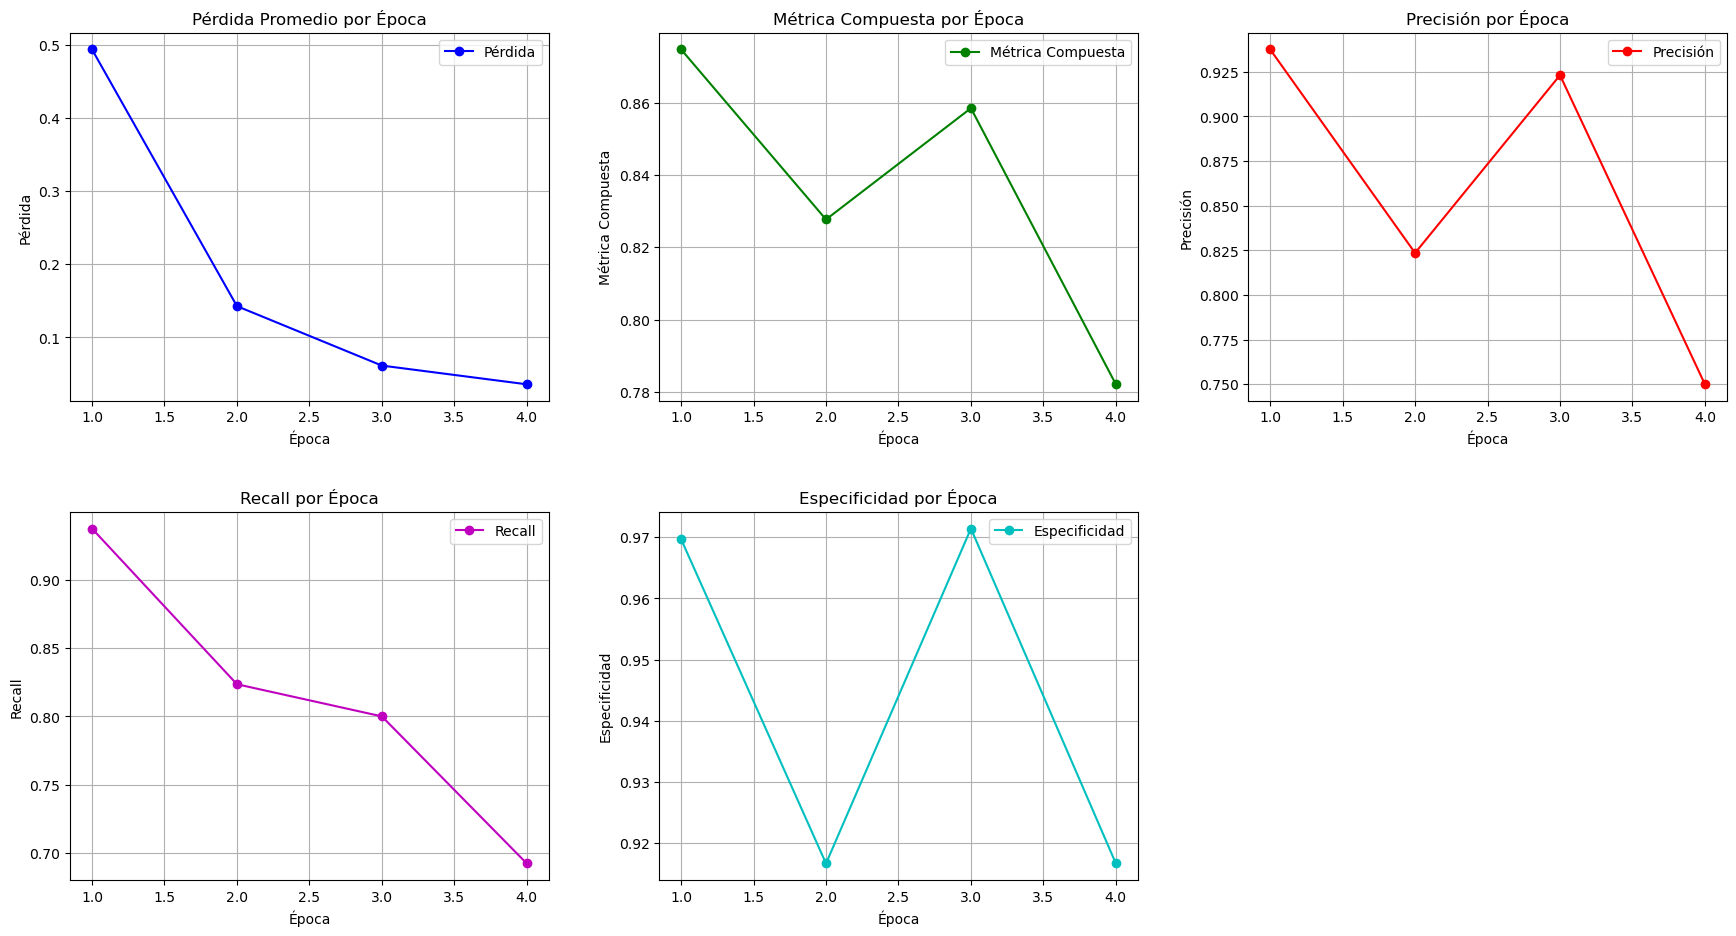

In [17]:
# Visualización de resultados
plt.figure(figsize=(18, 10))

# Valores proporcionados
epoch_loss_values = [0.49330741029680375, 0.14274863180992065, 0.06159004600935156, 0.03601786930075537]
metric_values = [0.8746865203761757, 0.8276876267748479, 0.8584413287861564, 0.7821396993810787]
precision_values = [0.9375, 0.8235294117647058, 0.9230769230769231, 0.75]
recall_values = [0.9375, 0.8235294117647058, 0.8, 0.6923076923076923]
specificity_values = [0.9696969696969697, 0.9166666666666666, 0.9714285714285714, 0.9166666666666666]

# Gráfico de la pérdida promedio por época
plt.subplot(2, 3, 1)
plt.plot(range(1, len(epoch_loss_values) + 1), epoch_loss_values, marker='o', linestyle='-', color='b', label='Pérdida')
plt.title("Pérdida Promedio por Época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.legend()
print(epoch_loss_values)
# Gráfico de la métrica compuesta por época
plt.subplot(2, 3, 2)
plt.plot(range(1, len(metric_values) + 1), metric_values, marker='o', linestyle='-', color='g', label='Métrica Compuesta')
plt.title("Métrica Compuesta por Época")
plt.xlabel("Época")
plt.ylabel("Métrica Compuesta")
plt.grid(True)
plt.legend()
print(metric_values)
# Gráfico de la precisión por época
plt.subplot(2, 3, 3)
plt.plot(range(1, len(precision_values) + 1), precision_values, marker='o', linestyle='-', color='r', label='Precisión')
plt.title("Precisión por Época")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.grid(True)
plt.legend()
print(precision_values)
     
# Gráfico del recall por época
plt.subplot(2, 3, 4)
plt.plot(range(1, len(recall_values) + 1), recall_values, marker='o', linestyle='-', color='m', label='Recall')
plt.title("Recall por Época")
plt.xlabel("Época")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()
print(recall_values)

# Gráfico de la especificidad por época
plt.subplot(2, 3, 5)
plt.plot(range(1, len(specificity_values) + 1), specificity_values, marker='o', linestyle='-', color='c', label='Especificidad')
plt.title("Especificidad por Época")
plt.xlabel("Época")
plt.ylabel("Especificidad")
plt.grid(True)
plt.legend()
print(specificity_values)
plt.tight_layout(pad=3.0)
plt.show()


## Evaluar el modelo con los datos de prueba

Total number of samples in the test dataset: 120
Total number of samples evaluated: 120
Accuracy: 0.6000
Precision: 0.5679
Recall: 0.6000
F1 Score: 0.5609


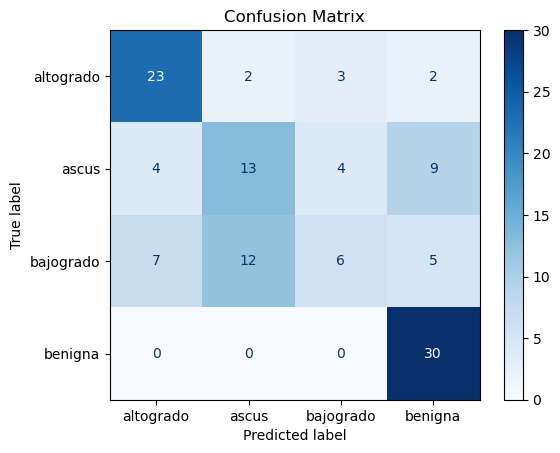

              precision    recall  f1-score   support

   altogrado     0.6765    0.7667    0.7188        30
       ascus     0.4815    0.4333    0.4561        30
   bajogrado     0.4615    0.2000    0.2791        30
     benigna     0.6522    1.0000    0.7895        30

    accuracy                         0.6000       120
   macro avg     0.5679    0.6000    0.5609       120
weighted avg     0.5679    0.6000    0.5609       120



In [44]:
# Cargar el mejor modelo
model.load_state_dict(torch.load(os.path.join(metric_dir, "mejor_modelo_pytorch.pth")))
model.eval()
y_true = []
y_pred = []

# Mostrar el número total de muestras en el conjunto de datos de prueba
print(f"Total number of samples in the test dataset: {len(test_loader.dataset)}")

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = torch.tensor([label_to_int[label] for label in test_labels]).to(device)
        
        # Realizar predicciones
        outputs = model(test_images)
        pred = outputs.argmax(dim=1)
        
        # Almacenar etiquetas verdaderas y predichas
        y_true.extend(test_labels.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

# Mostrar el número total de muestras evaluadas
print(f"Total number of samples evaluated: {len(y_true)}")

# Calcular y mostrar métricas de rendimiento
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names_train)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Mostrar el informe de clasificación
print(classification_report(y_true, y_pred, target_names=class_names_train, digits=4, zero_division=1))
